In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 110 kB 5.5 MB/s 
     |████████████████████████████████| 287 kB 41.3 MB/s 


In [ ]:
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sn
import random

import matplotlib.pyplot as plt

import contractions
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn import metrics


from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


https://www.analyticsvidhya.com/blog/2021/09/sentiment-classification-using-nlp-with-text-analytics/

# get data

In [ ]:
def get_detaset():
    train_df = pd.read_csv('/content/drive/MyDrive/IFT6390/kaggle2/train_data.csv')
    test_df = pd.read_csv('/content/drive/MyDrive/IFT6390/kaggle2/test_data.csv')
    train_result_df = pd.read_csv('/content/drive/MyDrive/IFT6390/kaggle2/train_results.csv')
    return train_df, test_df, train_result_df

def treat_detaset(train_df, test_df, train_result_df):
    train_df= train_df.drop(columns=['id'])
    test_df = test_df.drop(columns=['id'])
    train_result_df = train_result_df.drop(columns=['id'])

    train_result_df.loc[train_result_df['target'] == 'negative'] = 0
    train_result_df.loc[train_result_df['target'] == 'neutral'] = 1
    train_result_df.loc[train_result_df['target'] == 'positive'] = 2
    return train_df, test_df, train_result_df

In [ ]:
train_df, test_df, train_result_df = get_detaset()
train_df, test_df, train_result_df = treat_detaset(train_df, test_df, train_result_df)

In [ ]:
print('positive',train_df[train_result_df.target == 2][0:3])
print('neutral',train_df[train_result_df.target == 1][0:3])
print('negative',train_df[train_result_df.target == 0][0:3])

positive                                                 text
0                  Anyway Im getting of for a while 
2  @danyelljoy you should be  its great. friday w...
3  its 11:30pm and i dont wanna sleep; so i debat...
neutral                                                     text
11978                           Jake's going to safeway!
32510  Adobe CS4 commercial by Goodby Silverstein: ht...
66754          ok.. do nothing.. just thinking about 40D
negative                                                 text
1  My red, Apache isn't feelin too well this morn...
4          Why does twitter eat my DM's?  Not happy 
5  @mranstey hey there. Drivin north. I guess we ...


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040323 entries, 0 to 1040322
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1040323 non-null  object
dtypes: object(1)
memory usage: 7.9+ MB


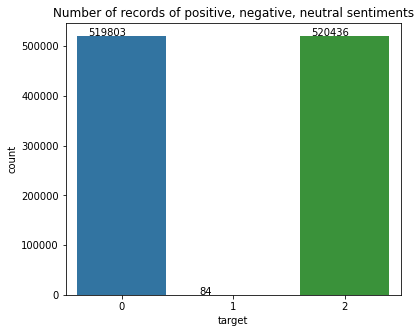

In [ ]:
plt.figure(figsize=(6,5))
plt.title("Number of records of positive, negative, neutral sentiments")
plot = sn.countplot(x = 'target', data=train_result_df)
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x()+0.1 ,p.get_height()+50))

# text preprocessing

https://www.analyticsvidhya.com/blog/2021/06/must-known-techniques-for-text-preprocessing-in-nlp/?

In [ ]:
#def stopwords
nltk.download('stopwords')
stop_words_list = stopwords.words('english')
stop_words = set(stop_words_list[:88])
#Only delete part of stopwords, keep not, no... that may affect emotion
stop_words.add('subject')
stop_words.add('http')

nltk.download("wordnet")
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

def text_preprocessing(df):
    #1) Expand contractions in Text Processing
    df['reviews_text']=df['text'].apply(lambda x:contractions.fix(x, slang=True))
    #2) Lower Case
    df['reviews_text'] = df['reviews_text'].str.lower()
    #3) Remove punctuations
    df['reviews_text'] = df['reviews_text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))
    #4) Remove words containing digits
    df['reviews_text'] = df['reviews_text'].apply(lambda x: re.sub(r'\w*\d\w*', '', x))
    #5) Remove Stopwords
    def remove_stopwords(text):
        return " ".join([word for word in str(text).split() if word not in stop_words])
    df['reviews_text'] = df['reviews_text'].apply(lambda x: remove_stopwords(x))
    #6) Lemmatization
    def lemmatize_words(text):
        return " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    df['reviews_text'] = df['reviews_text'].apply(lambda text: lemmatize_words(text))
    #7) Remove Extra Spaces
    df['reviews_text'] = df['reviews_text'].apply(lambda x: re.sub(' +', ' ', x))
    return df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
train_df_pre = text_preprocessing(train_df)
test_df_pre = text_preprocessing(test_df)

In [ ]:
train_df_pre.head(5)

,text,reviews_text
0,Anyway Im getting of for a while,anyway getting
1,"My red, Apache isn't feelin too well this morn...",red apache not feelin too well morning
2,@danyelljoy you should be its great. friday w...,danyelljoy should great friday will great tooo...
3,its 11:30pm and i dont wanna sleep; so i debat...,not want sleep so debated in end decided perfe...
4,Why does twitter eat my DM's? Not happy,why twitter eat dm not happy


In [ ]:
test_df_pre.head(5)

,text,reviews_text
0,so cut... missed out on all the TCE EXTREME ME...,so cut missed out on all tce extreme merch in ...
1,Thank you very much Wasin this is awesome lol,thank very much wasin awesome lol
2,Squeezing in some internet time before Dustin ...,squeezing in some internet time dustin go work
3,@fanoou; Oh i do have moral but i'm gonna be b...,fanoou oh moral going bigger eat mc donalds
4,@NSuissa I just bought Sammy some joint/hip ...,nsuissa just bought sammy some jointhip supple...


# **Creating Count Vectors (bag of words) for Dataset**

https://www.analyticsvidhya.com/blog/2021/08/text-preprocessing-techniques-for-performing-sentiment-analysis/#h2_3

In [ ]:
count_vectorize = CountVectorizer(max_features = 1000, min_df = 20)

def creating_count_vectors(df):
    feature_vector =  count_vectorize.fit(df.reviews_text)
    features = feature_vector.get_feature_names()
    ds_features = count_vectorize.transform(df.reviews_text)
    return features, ds_features

In [ ]:
 #get features(BOW) and transform data to BOW
 #features, train_ds_features = creating_count_vectors(train_df_pre)

train_ds_features = count_vectorize.fit_transform(train_df_pre.reviews_text)
test_ds_features = count_vectorize.transform(test_df_pre.reviews_text)

In [ ]:
random.sample(features,10)

['sick',
 'mood',
 'okay',
 'hit',
 'plan',
 'awful',
 'sooo',
 'pool',
 'favorite',
 'poor']

In [ ]:
type(train_ds_features)

scipy.sparse.csr.csr_matrix

In [ ]:
print("Density of the matrix(%): ", train_ds_features.getnnz()*100/
    (train_ds_features.shape[0]*train_ds_features.shape[1]))。

Density of the matrix(%):  0.5653042372417029


# **Build Model for sentiment classification**

In [ ]:
#splid train valid
train_x, valid_x, train_y, valid_y =  train_test_split(train_ds_features, train_result_df.target, 
                                                     test_size = 0.2, random_state = 42)

              precision    recall  f1-score   support

           0       0.75      0.75      0.75    103891
           1       0.00      0.00      0.00        18
           2       0.75      0.75      0.75    104156

    accuracy                           0.75    208065
   macro avg       0.50      0.50      0.50    208065
weighted avg       0.75      0.75      0.75    208065



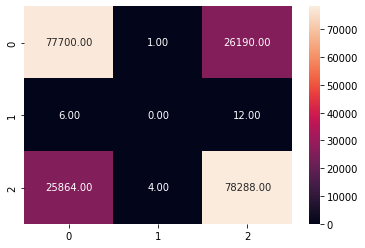

In [ ]:
#train and valid
nb_clf = MultinomialNB()
nb_clf.fit(train_x.toarray(), train_y.astype(int))
test_ds_predicted = nb_clf.predict(valid_x.toarray())
print(metrics.classification_report(valid_y.astype(int),test_ds_predicted))
cm = metrics.confusion_matrix(valid_y.astype(int), test_ds_predicted)
sn.heatmap(cm, annot=True, fmt = '.2f')

In [ ]:
test_ds_features

<560175x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 3160536 stored elements in Compressed Sparse Row format>

In [ ]:
test_predicted = nb_clf.predict(test_ds_features.toarray())

In [ ]:
df_submit = pd.DataFrame(test_predicted, columns = ['target'])
df_submit = df_submit.reset_index()
df_submit.rename(columns={'index':'id'}, inplace = True)

In [ ]:
df_submit

,id,target
0,0,0
1,1,2
2,2,0
3,3,0
4,4,0
...,...,...
560170,560170,0
560171,560171,0
560172,560172,0
560173,560173,2


In [ ]:
df_submit.to_csv('./bayes3.csv', index = False)

# **Creating Count Vectors (bag of words) for Dataset**
# + TF-IDF


In [ ]:
count_vectorize_T = TfidfVectorizer(max_features = 1000, min_df = 20)

train_ds_features_T = count_vectorize_T.fit_transform(train_df_pre.reviews_text)
test_ds_features_T = count_vectorize_T.transform(test_df_pre.reviews_text)

In [ ]:
#splid train valid
train_x, valid_x, train_y, valid_y =  train_test_split(train_ds_features_T, train_result_df.target, 
                                                     test_size = 0.2, random_state = 42)

              precision    recall  f1-score   support

           0       0.75      0.74      0.74    103891
           1       0.00      0.00      0.00        18
           2       0.74      0.75      0.75    104156

    accuracy                           0.75    208065
   macro avg       0.50      0.50      0.50    208065
weighted avg       0.75      0.75      0.75    208065



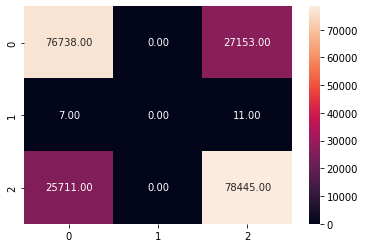

In [ ]:
#train and valid
nb_clf = MultinomialNB()
nb_clf.fit(train_x.toarray(), train_y.astype(int))
test_ds_predicted = nb_clf.predict(valid_x.toarray())
print(metrics.classification_report(valid_y.astype(int),test_ds_predicted))
cm = metrics.confusion_matrix(valid_y.astype(int), test_ds_predicted)
sn.heatmap(cm, annot=True, fmt = '.2f')